In [167]:
import os
from importlib import reload

import torch
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle

from src import main, plots
from src.utils import data
from src.utils.utils import open_config
from src.utils.clustering import CompactClusterEncoder

torch.serialization.add_safe_globals([CompactClusterEncoder])
reload(data)
reload(main)
# reload(single_plots)
from src.main import init

In [179]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']
bahamas_colours = ['#0049E0', '#0090E0', '#00D7E0', '#2CDEE6', '#00E09E', '#00E051'][:-2]
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA2100', '#FA7700']
flamingo_test = ['#FA07A0']
known = [
    # 'flamingo',
    # 'flamingo_low',
    # 'flamingo_hi',
    'bahamas_cdm',
    'bahamas_cdm_low',
    'bahamas_cdm_hi',
    'bahamas_0.1',
    'bahamas_0.3',
    'bahamas_1',
]
unknown = [
    'flamingo_low_test',
    # 'bahamas_cdm_low',
    # 'bahamas_cdm_hi',
    # 'noise',
]
colours = ['k'] + bahamas_agn_colours + bahamas_colours

In [180]:
# Initialise network
loaders, net, dataset = init(known, config, unknown=unknown)

# Train network
net.training(net_epochs, loaders)

# Generate predictions
data = net.predict(loaders[1])
# data['targets'] = dataset.correct_unknowns(data['targets'].squeeze())
data['targets'] = data['targets'].squeeze()
labels = dataset.names[data['ids'][np.unique(
    data['targets'],
    return_index=True,
)[1]].astype(int)]


Training data size: 21280	Validation data size: 5320

Final validation loss: 2.355e-01
Prediction time: 1.350e+00 s


In [181]:
# data['latent'][:, 0] *= 1e6
pca = PCA(n_components=4).fit(data['latent'][np.isin(data['targets'], np.unique(data['targets'])[net._unknown:])])
# pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])
# pca_transform[:, 0] /= 1e6
# data['latent'][:, 0] /= 1e6

In [198]:
latent = [[], []]
slice_ = slice(1,7)
for target in np.unique(data['targets'])[slice_]:
    idxs = data['targets'] == target
    latent[0].append(pca_transform[idxs, 0])
    latent[1].append(pca_transform[idxs, 1])


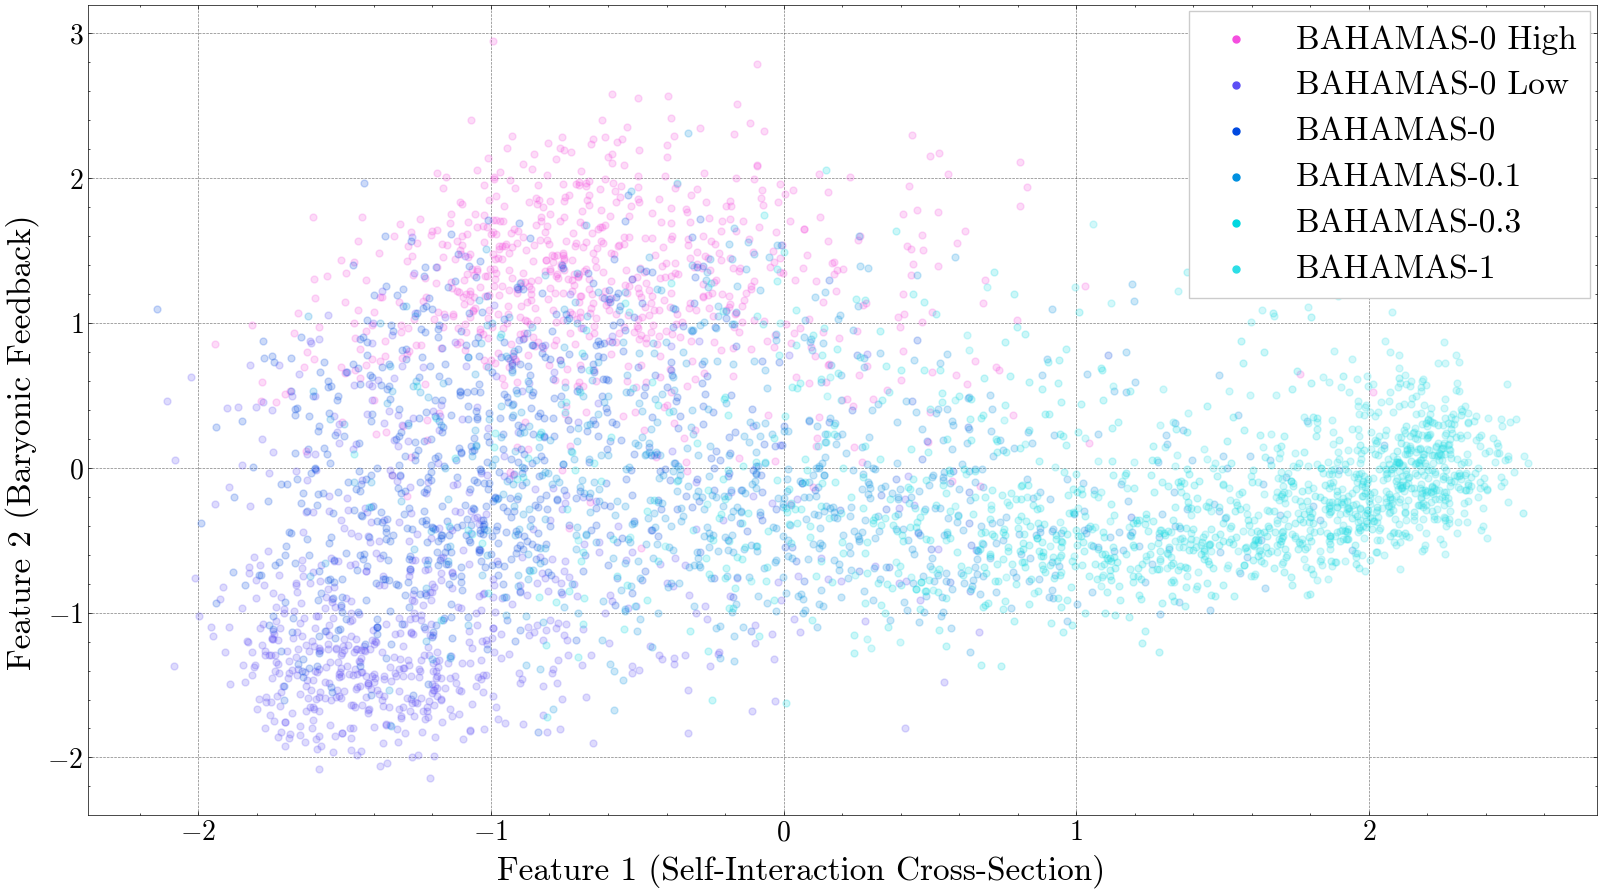

In [199]:
plot = plots.PlotPlots(
    latent[0],
    latent[1],
    # x_label='Feature 1',
    # y_label='Feature 2',
    x_label='Feature 1 (Self-Interaction Cross-Section)',
    y_label='Feature 2 (Baryonic Feedback)',
    alpha=0.2,
    alpha_2d=0.2,
    colours=colours[slice_],
    labels=labels[slice_],
    markers='.',
    fig_size=(16, 9),
    axis=True,
    rows=len(labels[slice_]),
    loc='best'
)

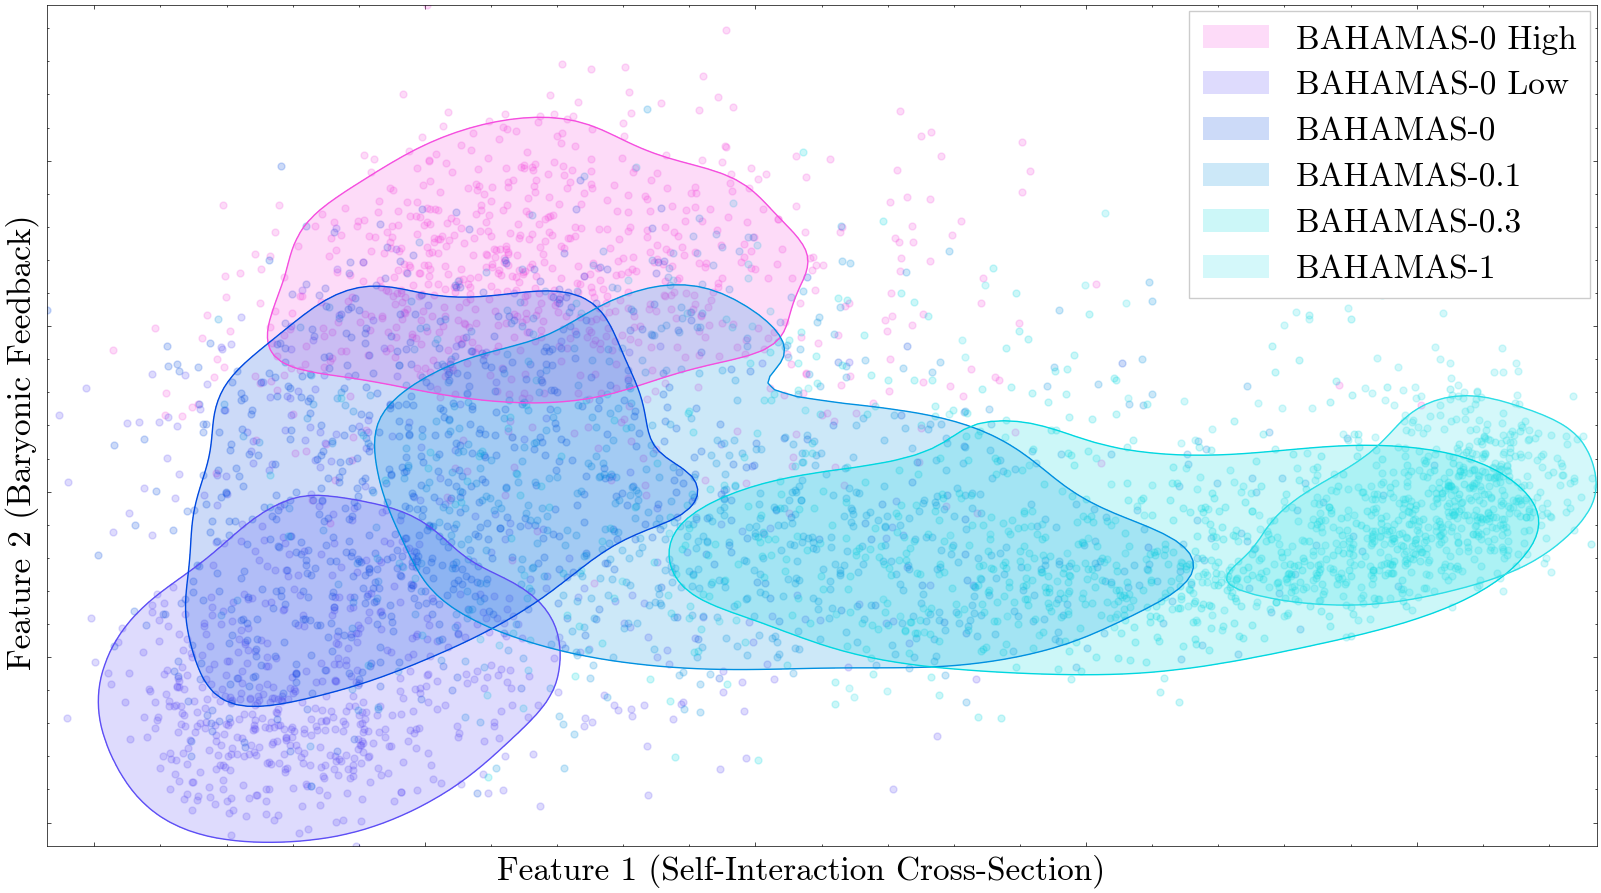

In [200]:
for colour, x_data, y_data in zip(colours[slice_], plot._data, plot._y_data):
    plot.plot_density(colour, np.stack((x_data, y_data), axis=-1), np.array(([np.min(x_data), np.max(x_data)], [np.min(y_data), np.max(y_data)])), plot.axes)

plot.axes.set_xticklabels([])
plot.axes.set_yticklabels([])
plot.axes.set_xlim([np.min(pca_transform[:, 0]), np.max(pca_transform[:, 0])])
plot.axes.set_ylim([np.min(pca_transform[:, 1]), np.max(pca_transform[:, 1])])
plot.axes.grid()
plot.create_legend(**plot._legend_kwargs)
plot.plots = [plot for plot in plot.plots.copy() if isinstance(plot, Rectangle)]
plot.create_legend(**plot._legend_kwargs)
# plot.fig._supxlabel.set_fontsize(72)
# plot.fig._supylabel.set_fontsize(72)
plot.fig

In [201]:
plot.savefig('../plots/', name='test')

In [197]:
net = net.to('cpu')
torch.cuda.empty_cache()